In [1]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
import tensorflow
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pickle

In [2]:
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # T5

## SMS Spam Data

In [37]:
df = pd.read_csv("/content/drive/MyDrive/sms_v2.csv")

In [38]:
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/t5/sms_aug_t5.csv")

In [39]:
df.columns
df.rename(columns={'Rofl. Its true to its name': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [40]:
augmented_dataset.columns
augmented_dataset.rename(columns={'Its true to its name is Rofl.': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [41]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)
df_top.count()

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)
df_tail.count()


Message     997
Category    997
dtype: int64

In [42]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

In [43]:
df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [44]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

### BAŞTA

In [45]:
df_top["Message"] = df_top.Message.map(preprocess) 

In [46]:
maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
  try:
      cur = len(df_top["Message"][i])
      if (cur > maxSeq):
          maxSeq = cur
  except:
      pass

In [47]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

In [48]:
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [49]:
X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (977, 590)


In [50]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (977,)


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 590) (732,)
(245, 590) (245,)


In [52]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [53]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(16))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 2s 146ms/step - loss: 0.6780 - accuracy: 0.8222 - val_loss: 0.6556 - val_accuracy: 0.8844
Epoch 2/10
5/5 [==============================] - 0s 37ms/step - loss: 0.6364 - accuracy: 0.8974 - val_loss: 0.6136 - val_accuracy: 0.8776
Epoch 3/10
5/5 [==============================] - 0s 28ms/step - loss: 0.5863 - accuracy: 0.8923 - val_loss: 0.5603 - val_accuracy: 0.8707
Epoch 4/10
5/5 [==============================] - 0s 27ms/step - loss: 0.5234 - accuracy: 0.8957 - val_loss: 0.4936 - val_accuracy: 0.8707
Epoch 5/10
5/5 [==============================] - 0s 28ms/step - loss: 0.4470 - accuracy: 0.8940 - val_loss: 0.4197 - val_accuracy: 0.8707
Epoch 6/10
5/5 [==============================] - 0s 28ms/step - loss: 0.3694 - accuracy: 0.8940 - val_loss: 0.3502 - val_accuracy: 0.8707
Epoch 7/10
5/5 [==============================] - 0s 28ms/step - loss: 0.3018 - accuracy: 0.8940 - val_loss: 0.2940 - val_accuracy: 0.8707
Epoch 8/10
5/5 [==========

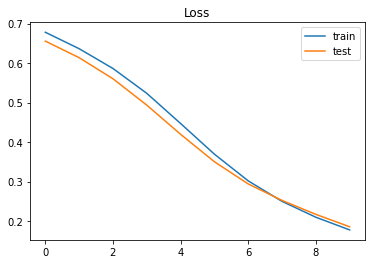

In [54]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


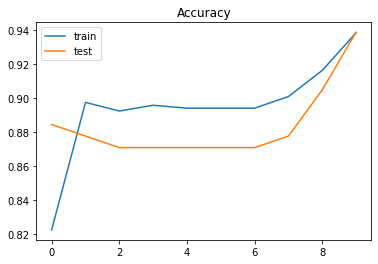

In [55]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [56]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)


8/8 - 0s - 434ms/epoch - 54ms/step


In [57]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

    not spam       0.93      1.00      0.96       210
        spam       1.00      0.51      0.68        35

    accuracy                           0.93       245
   macro avg       0.96      0.76      0.82       245
weighted avg       0.94      0.93      0.92       245



In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

,not spam,spam
not spam,210,0
spam,17,18


### ORTADA

In [59]:
df_mid["Message"] = df_mid.Message.map(preprocess) 
maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
  try:
      cur = len(df_mid["Message"][i])
      if (cur > maxSeq):
          maxSeq = cur
  except:
      pass

In [60]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (977, 590)


In [61]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (977,)


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 590) (732,)
(245, 590) (245,)


In [63]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())


Epoch 1/10
5/5 [==============================] - 2s 158ms/step - loss: 0.6795 - accuracy: 0.7333 - val_loss: 0.6433 - val_accuracy: 0.8639
Epoch 2/10
5/5 [==============================] - 0s 37ms/step - loss: 0.6161 - accuracy: 0.8872 - val_loss: 0.5706 - val_accuracy: 0.8571
Epoch 3/10
5/5 [==============================] - 0s 35ms/step - loss: 0.5218 - accuracy: 0.8821 - val_loss: 0.4526 - val_accuracy: 0.8571
Epoch 4/10
5/5 [==============================] - 0s 37ms/step - loss: 0.3733 - accuracy: 0.8821 - val_loss: 0.3445 - val_accuracy: 0.8571
Epoch 5/10
5/5 [==============================] - 0s 33ms/step - loss: 0.2894 - accuracy: 0.8821 - val_loss: 0.3575 - val_accuracy: 0.8571
Epoch 6/10
5/5 [==============================] - 0s 33ms/step - loss: 0.2771 - accuracy: 0.8821 - val_loss: 0.3164 - val_accuracy: 0.8571
Epoch 7/10
5/5 [==============================] - 0s 34ms/step - loss: 0.2177 - accuracy: 0.8906 - val_loss: 0.2435 - val_accuracy: 0.8776
Epoch 8/10
5/5 [==========

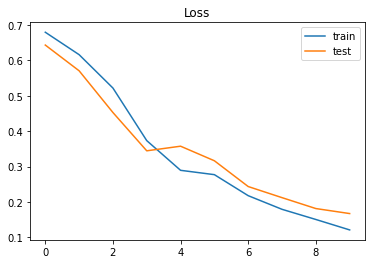

In [64]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

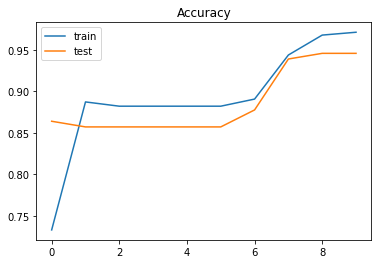

In [65]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [66]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

8/8 - 0s - 385ms/epoch - 48ms/step


In [67]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df


              precision    recall  f1-score   support

    not spam       0.95      1.00      0.98       217
        spam       1.00      0.61      0.76        28

    accuracy                           0.96       245
   macro avg       0.98      0.80      0.87       245
weighted avg       0.96      0.96      0.95       245



,not spam,spam
not spam,217,0
spam,11,17


### SONDA

In [68]:
df_tail["Message"] = df_tail.Message.map(preprocess) 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass
      
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

#ÖN İŞLEME-5
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#ÖN İŞLEME-6    
X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

#ÖN İŞLEME-7
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)


Shape of data tensor: (977, 590)
Shape of label tensor: (977,)


In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 590) (732,)
(245, 590) (245,)


In [70]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [71]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 3s 150ms/step - loss: 0.6794 - accuracy: 0.7778 - val_loss: 0.6530 - val_accuracy: 0.8707
Epoch 2/10
5/5 [==============================] - 0s 45ms/step - loss: 0.6302 - accuracy: 0.8923 - val_loss: 0.5928 - val_accuracy: 0.8707
Epoch 3/10
5/5 [==============================] - 0s 32ms/step - loss: 0.5488 - accuracy: 0.8906 - val_loss: 0.4903 - val_accuracy: 0.8707
Epoch 4/10
5/5 [==============================] - 0s 32ms/step - loss: 0.4291 - accuracy: 0.8906 - val_loss: 0.3903 - val_accuracy: 0.8707
Epoch 5/10
5/5 [==============================] - 0s 34ms/step - loss: 0.3399 - accuracy: 0.8906 - val_loss: 0.3575 - val_accuracy: 0.8707
Epoch 6/10
5/5 [==============================] - 0s 34ms/step - loss: 0.3112 - accuracy: 0.8906 - val_loss: 0.3506 - val_accuracy: 0.8707
Epoch 7/10
5/5 [==============================] - 0s 32ms/step - loss: 0.2860 - accuracy: 0.8906 - val_loss: 0.3153 - val_accuracy: 0.8707
Epoch 8/10
5/5 [==========

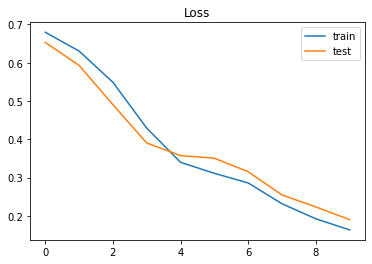

In [72]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

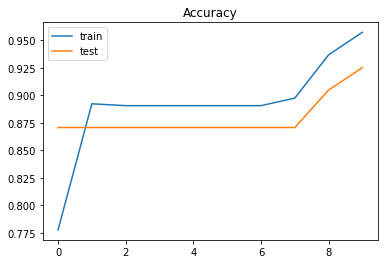

In [73]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [74]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)


8/8 - 0s - 437ms/epoch - 55ms/step


In [76]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df


              precision    recall  f1-score   support

    not spam       0.93      1.00      0.97       210
        spam       1.00      0.57      0.73        35

    accuracy                           0.94       245
   macro avg       0.97      0.79      0.85       245
weighted avg       0.94      0.94      0.93       245



,not spam,spam
not spam,210,0
spam,15,20


## Twitter Sentiment Analysis

In [77]:
df = pd.read_csv("/content/drive/MyDrive/sentiment_v2.csv")
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/t5/sentiment_aug_t5.csv")

In [78]:
df.rename(columns={'RT  NancyLeeGrahn  How did everyone feel about the Climate Change question last night  Exactly.  GOPDebate': 'Message', 'Neutral': 'Category'}, inplace=True)
augmented_dataset.rename(columns={'RT NancyLeeGrahn How did everyone feel yesterday about the climate change question Exactly.': 'Message', 'Neutral': 'Category'}, inplace=True)

In [79]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)

In [80]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

In [81]:
"""df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)"""

"df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)\ndf_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)\ndf_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)"

In [82]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

###BAŞTA

In [83]:
df_top["Message"] = df_top.Message.map(preprocess) 

maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
    try:
        cur = len(df_top["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (998, 160)
Shape of label tensor: (998,)


In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#MODEL KURULMASI
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(748, 160) (748,)
(250, 160) (250,)
Epoch 1/10
5/5 [==============================] - 2s 122ms/step - loss: 0.6875 - accuracy: 0.3110 - val_loss: 0.6793 - val_accuracy: 0.2400
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6614 - accuracy: 0.2308 - val_loss: 0.6583 - val_accuracy: 0.2400
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.6239 - accuracy: 0.2274 - val_loss: 0.6265 - val_accuracy: 0.2400
Epoch 4/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5656 - accuracy: 0.2274 - val_loss: 0.5835 - val_accuracy: 0.2400
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 0.4887 - accuracy: 0.2274 - val_loss: 0.5388 - val_accuracy: 0.2400
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 0.3638 - accuracy: 0.2625 - val_loss: 0.4553 - val_accuracy: 0.2867
Epoch 7/10
5/5 [==============================] - 0s 15ms/step - loss: 0.1770 - accuracy: 0.4716 - val_loss: 0.3430 - val_accurac

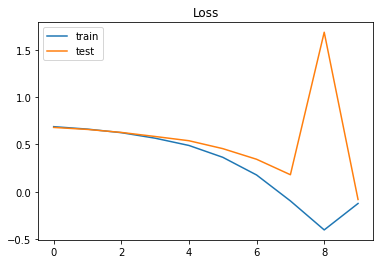

In [85]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

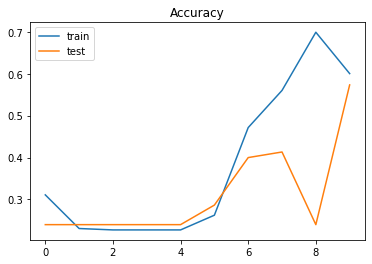

In [86]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [87]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 365ms/epoch - 46ms/step
              precision    recall  f1-score   support

    positive       0.97      0.62      0.76       146
    negative       0.37      0.97      0.54        60
     neutral       0.00      0.00      0.00        44

    accuracy                           0.60       250
   macro avg       0.45      0.53      0.43       250
weighted avg       0.65      0.60      0.57       250



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,91,55,0
negative,2,58,0
neutral,1,43,0


### ORTADA

In [88]:
df_mid["Message"] = df_mid.Message.map(preprocess) 

maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
    try:
        cur = len(df_mid["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (998, 160)
Shape of label tensor: (998,)


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#MODEL KURULMASI
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(748, 160) (748,)
(250, 160) (250,)
Epoch 1/10
5/5 [==============================] - 2s 120ms/step - loss: 0.6885 - accuracy: 0.2910 - val_loss: 0.6781 - val_accuracy: 0.1867
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6654 - accuracy: 0.2458 - val_loss: 0.6572 - val_accuracy: 0.1867
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6334 - accuracy: 0.2425 - val_loss: 0.6223 - val_accuracy: 0.1867
Epoch 4/10
5/5 [==============================] - 0s 19ms/step - loss: 0.5782 - accuracy: 0.2425 - val_loss: 0.5795 - val_accuracy: 0.1867
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5161 - accuracy: 0.2408 - val_loss: 0.5267 - val_accuracy: 0.1867
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.4063 - accuracy: 0.3227 - val_loss: 0.4575 - val_accuracy: 0.2933
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 0.2423 - accuracy: 0.4649 - val_loss: 0.3693 - val_accurac

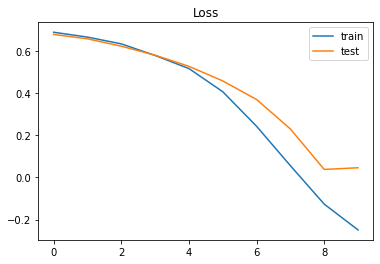

In [90]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

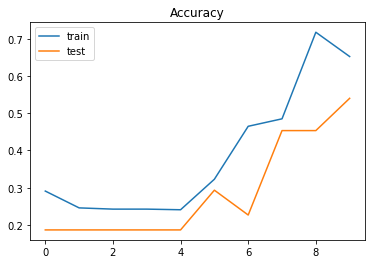

In [91]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [92]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 351ms/epoch - 44ms/step
              precision    recall  f1-score   support

    positive       0.92      0.73      0.82       146
    negative       0.40      0.90      0.56        60
     neutral       0.00      0.00      0.00        44

    accuracy                           0.64       250
   macro avg       0.44      0.54      0.46       250
weighted avg       0.64      0.64      0.61       250



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,107,39,0
negative,6,54,0
neutral,3,41,0


###SONDA

In [93]:
df_tail["Message"] = df_tail.Message.map(preprocess) 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (998, 160)
Shape of label tensor: (998,)


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(748, 160) (748,)
(250, 160) (250,)
Epoch 1/10
5/5 [==============================] - 2s 118ms/step - loss: 0.6862 - accuracy: 0.2341 - val_loss: 0.6706 - val_accuracy: 0.2400
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6561 - accuracy: 0.2274 - val_loss: 0.6418 - val_accuracy: 0.2400
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.6253 - accuracy: 0.2274 - val_loss: 0.6119 - val_accuracy: 0.2400
Epoch 4/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5819 - accuracy: 0.2274 - val_loss: 0.5859 - val_accuracy: 0.2400
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5206 - accuracy: 0.2274 - val_loss: 0.5430 - val_accuracy: 0.2400
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 0.4270 - accuracy: 0.2358 - val_loss: 0.4763 - val_accuracy: 0.2533
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 0.2776 - accuracy: 0.3729 - val_loss: 0.3786 - val_accurac

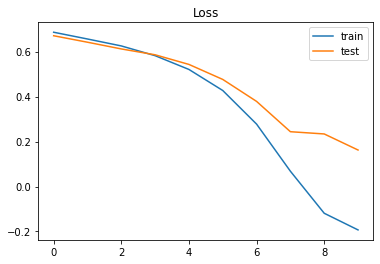

In [95]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

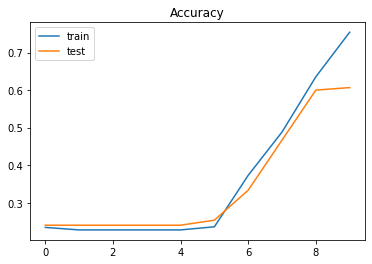

In [96]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [97]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 360ms/epoch - 45ms/step
              precision    recall  f1-score   support

    positive       0.96      0.71      0.81       146
    negative       0.40      0.95      0.56        60
     neutral       0.00      0.00      0.00        44

    accuracy                           0.64       250
   macro avg       0.45      0.55      0.46       250
weighted avg       0.66      0.64      0.61       250



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,103,43,0
negative,3,57,0
neutral,1,43,0


## Fake News Data

In [98]:
df = pd.read_csv("/content/drive/MyDrive/news_v2.csv")
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/t5/news_aug_t5.csv")

In [101]:
df.rename(columns={'print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why did it take two years to bust them  here we go again another group stealing from the government and taxpayers a group of somalis stole over four million in government benefits over just  months  weve reported on numerous cases like this one where the muslim refugeesimmigrants commit fraud by scamming our systemits way out of control more related': 'Message', 'Real': 'Category'}, inplace=True)
augmented_dataset.rename(columns={'We follow another group stealing from the government and taxpayers a group of somalis stole over four million dollars in government benefits over just months we reported on numerous cases such as this where muslim refugees are fraudsters by scamming our system its way out of control': 'Message', 'Real': 'Category'}, inplace=True)

In [104]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)

In [105]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

### BAŞTA

In [106]:
df_top["Message"] = df_top["Message"].str.lower()

In [107]:
df_top['Message']= df_top['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
    try:
        cur = len(df_top["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

<ipython-input-107-7ca10b9392c7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_top['Message']= df_top['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [108]:
df_top.dropna(inplace=True)

In [109]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (963, 29508)
Shape of label tensor: (963,)


In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(722, 29508) (722,)
(241, 29508) (241,)


In [111]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 0.6782 - accuracy: 0.8198 - val_loss: 0.6517 - val_accuracy: 0.8897
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6240 - accuracy: 0.8977 - val_loss: 0.5915 - val_accuracy: 0.8759
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5363 - accuracy: 0.8960 - val_loss: 0.4852 - val_accuracy: 0.8759
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.3926 - accuracy: 0.8960 - val_loss: 0.3548 - val_accuracy: 0.8759
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.2920 - accuracy: 0.8960 - val_loss: 0.3633 - val_accuracy: 0.8759
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.2943 - accuracy: 0.8960 - val_loss: 0.3553 - val_accuracy: 0.8759
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.2620 - accuracy: 0.8960 - val_loss: 0.3141 - val_accuracy: 0.8759
Epoch 8/10
5/5 [=========================

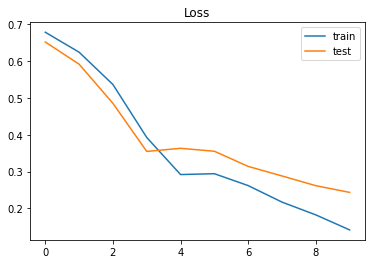

In [114]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

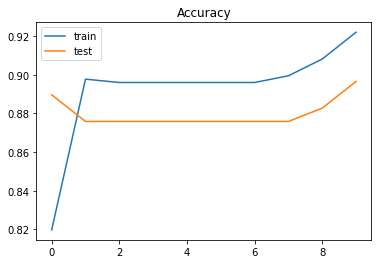

In [115]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [116]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 383ms/step
              precision    recall  f1-score   support

        real       0.90      1.00      0.95       216
        fake       1.00      0.04      0.08        25

    accuracy                           0.90       241
   macro avg       0.95      0.52      0.51       241
weighted avg       0.91      0.90      0.86       241



,real,fake
real,216,0
fake,24,1


### ORTADA

In [117]:
df_mid["Message"] = df_mid["Message"].str.lower()

In [118]:
df_mid['Message']= df_mid['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
    try:
        cur = len(df_mid["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

df_mid.dropna(inplace=True)

<ipython-input-118-ea2990828e20>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mid['Message']= df_mid['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [119]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (963, 29508)
Shape of label tensor: (963,)


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(722, 29508) (722,)
(241, 29508) (241,)


In [121]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 0.6828 - accuracy: 0.7643 - val_loss: 0.6616 - val_accuracy: 0.8828
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6421 - accuracy: 0.8873 - val_loss: 0.6168 - val_accuracy: 0.8828
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5804 - accuracy: 0.8873 - val_loss: 0.5407 - val_accuracy: 0.8828
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.4769 - accuracy: 0.8873 - val_loss: 0.4008 - val_accuracy: 0.8828
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3198 - accuracy: 0.8873 - val_loss: 0.3373 - val_accuracy: 0.8828
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.3040 - accuracy: 0.8873 - val_loss: 0.3218 - val_accuracy: 0.8828
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 0.2601 - accuracy: 0.8891 - val_loss: 0.2929 - val_accuracy: 0.8828
Epoch 8/10
5/5 [=========================

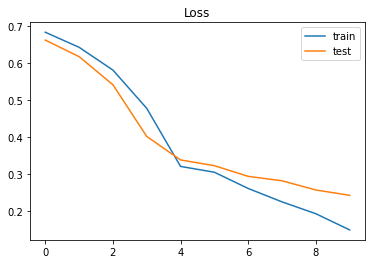

In [122]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

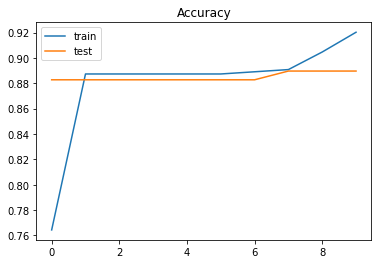

In [123]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [124]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 375ms/step
              precision    recall  f1-score   support

        real       0.92      1.00      0.96       220
        fake       1.00      0.10      0.17        21

    accuracy                           0.92       241
   macro avg       0.96      0.55      0.57       241
weighted avg       0.93      0.92      0.89       241



,real,fake
real,220,0
fake,19,2


###SONDA

In [125]:
df_tail["Message"] = df_tail["Message"].str.lower()
df_tail['Message']= df_tail['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

df_tail.dropna(inplace=True)

<ipython-input-125-a006ec4b28a2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tail['Message']= df_tail['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [126]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (963, 29508)
Shape of label tensor: (963,)


In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(722, 29508) (722,)
(241, 29508) (241,)


In [128]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 0.6848 - accuracy: 0.7331 - val_loss: 0.6679 - val_accuracy: 0.8276
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6381 - accuracy: 0.9099 - val_loss: 0.6144 - val_accuracy: 0.8276
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5369 - accuracy: 0.9099 - val_loss: 0.5016 - val_accuracy: 0.8276
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.3735 - accuracy: 0.9099 - val_loss: 0.4510 - val_accuracy: 0.8276
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.2958 - accuracy: 0.9099 - val_loss: 0.4899 - val_accuracy: 0.8276
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.2847 - accuracy: 0.9099 - val_loss: 0.5130 - val_accuracy: 0.8276
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.2815 - accuracy: 0.9099 - val_loss: 0.5046 - val_accuracy: 0.8276
Model: "sequential_11"
__________________

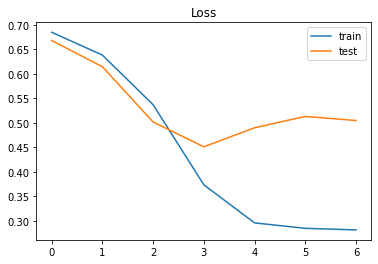

In [129]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

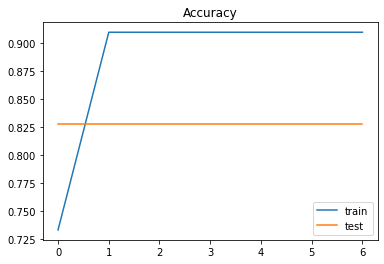

In [130]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [132]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 343ms/step
              precision    recall  f1-score   support

        real       0.89      1.00      0.94       215
        fake       0.00      0.00      0.00        26

    accuracy                           0.89       241
   macro avg       0.45      0.50      0.47       241
weighted avg       0.80      0.89      0.84       241



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,real,fake
real,215,0
fake,26,0
